# 1.0 - IMPORTS

## 1.1 - LIBRARIES

In [136]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
from scikitplot.metrics         import plot_cumulative_gain, cumulative_gain_curve
from sklearn.preprocessing      import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection    import train_test_split
from sklearn.ensemble           import ExtraTreesClassifier
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.linear_model       import LogisticRegression

## 1.2 - LOAD DATA

In [137]:
df = pd.read_csv('../dataset/train.csv', low_memory = True)

## 1.3 - HELPER FUNCTION

### 1.3.1 - PLOT DIMENTIONS

In [138]:
sns.set(rc = {'figure.figsize':(13,5)})

### 1.3.2 - OUTLIERS VOLUMETRY

In [139]:
def outliers_volumetry(data):
    
    df_num = pd.DataFrame()
    df_num = data.select_dtypes(exclude = 'object')
    outlier = []

    for i in df_num.columns:
        q1 = np.quantile(df_num[i], 0.25)
        q3 = np.quantile(df_num[i], 0.75)
        interquartile_distance = q3 - q1
        upper_limit = q3 + 1.5 * interquartile_distance
        lower_limit = q1 - 1.5 * interquartile_distance
        outliers = 0
        for j in df_num.index:
            if df_num[i][j] > upper_limit:
                outliers = outliers + 1
            elif df_num[i][j] < lower_limit:
                outliers = outliers + 1
            else:
                pass

        outlier.append(outliers)

    df_outlier = pd.DataFrame()
    df_outlier['attributes']    = df_num.columns
    df_outlier['quantity']      =   outlier
    df_outlier['percentual']    =   (outlier/df_num['id'].count())*100

    return df_outlier     

### 1.3.3 - PRECISION K METRIC

In [259]:
def precision_k(data, k = 2000):

    #sort list by high value of column
    data = data.sort_values('propensity_score', ascending = False)

    #reset index
    data = data.reset_index(drop = True)

    #create feature 'Ranking'
    data['ranking'] = data.index + 1
    
    #calcule precision K
    data['precision_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_k']

### 1.3.4 - RECALL K METRIC

In [260]:
def recall_k(data, k = 2000):

    #sort list by high value of column
    data = data.sort_values('propensity_score', ascending = False)
    
    #reset index
    data = data.reset_index(drop = True)

    #create feature 'Ranking'
    data['ranking'] = data.index + 1
    
    #calcule precision K
    data['recall_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_k']

# 2.0 - DATA CLEANING

In [140]:
df2 = df.copy()

## 2.1 - DATA DIMENTIONS

In [141]:
print('Number of rows: {}'.format(df.shape[0]))
print('Number of cols: {}'.format(df.shape[1]))
result = df2.apply(lambda x: x.nunique())
print('\nNumber of unique data of each feature: \n {}'.format(result))

Number of rows: 381109
Number of cols: 12

Number of unique data of each feature: 
 id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64


## 2.2 - RENAME COLUMNS

In [142]:
df2.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [143]:
df2.columns = df2.columns.str.lower()
df2.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 2.3 - DATA TYPES

In [144]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [145]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2.4 - CHECK NAN VOLUMETRY

In [146]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 2.5 - CHECK NULL VOLUMETRY

In [147]:
df2.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 2.6 - CHECK DUPLICATES VOLUMETRY

In [148]:
duplicated_rows = df2[df2.duplicated()]
print('Number of duplicated rows: {}'.format(duplicated_rows.shape[0]))

Number of duplicated rows: 0


## 2.7 - CHECK OUTLIER VOLUMETRY

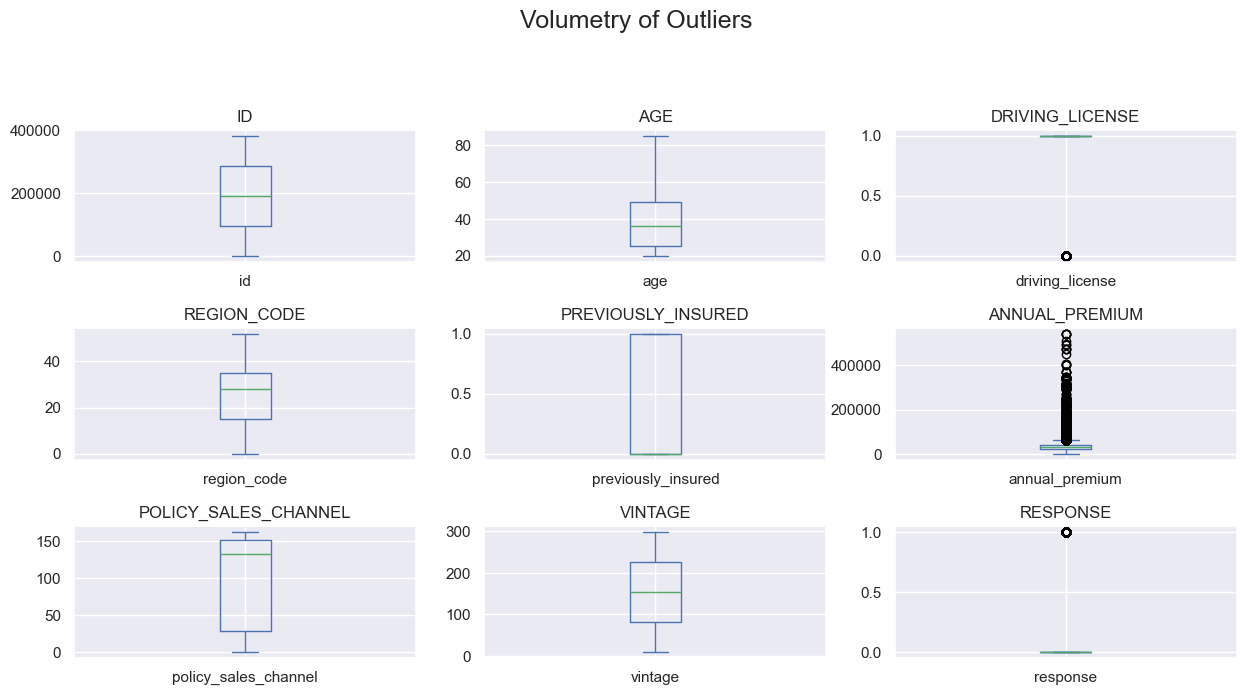

In [149]:
df_numerical = df2.select_dtypes(exclude = 'object')

# Creating the subplots for the dashbord of the boxplot

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Volumetry of Outliers", fontsize=18)

# loop through the length of pointer and keep track of index
for n, pointer in enumerate(df_numerical.columns):
    
    # add a new subplot iteratively
    ax = plt.subplot(5, 3, n + 1)

    # create a boxplot for the pointer on the new subplot axis
    df_numerical[pointer].plot(kind='box', ax=ax)

    # chart formatting
    ax.set_title(pointer.upper())
    ax.set_xlabel("")

plt.show()

In [150]:
outliers_volumetry(df2)

,attributes,quantity,percentual
0,id,0,0.000000
1,age,0,0.000000
2,driving_license,812,0.213062
3,region_code,0,0.000000
4,previously_insured,0,0.000000
5,annual_premium,10320,2.707887
6,policy_sales_channel,0,0.000000
7,vintage,0,0.000000
8,response,46710,12.256336


# 3.0 - STATICTICAL DESCRIPTIVE

In [151]:
df3 = df2.copy()

Tracking the dataset into numerical and categorical features:


In [152]:
df2_num = pd.DataFrame()
df2_cat = pd.DataFrame()

df2_num = df3.select_dtypes(exclude = 'object')
df2_cat = df3.select_dtypes(include = 'object')

## 3.1 - NUMERICAL ATTRIBUTES

In [153]:
# Tendence central:
# - Mean
# - Median

central_tendence1 = pd.DataFrame(df2_num.apply(lambda x: np.mean(x))).T
central_tendence2 = pd.DataFrame(df2_num.apply(lambda x: np.median(x))).T

# Dispersion:
# - Max
# - Min
# - Range
# - Standart Deviation
# - Skew
# - Kurtosis

dispersion1 = pd.DataFrame(df2_num.apply(lambda x: np.std(x))).T
dispersion2 = pd.DataFrame(df2_num.apply(min)).T
dispersion3 = pd.DataFrame(df2_num.apply(max)).T
dispersion4 = pd.DataFrame(df2_num.apply(lambda x: x.min() - x.max())).T
dispersion5 = pd.DataFrame(df2_num.apply(lambda x: x.skew())).T
dispersion6 = pd.DataFrame(df2_num.apply(lambda x: x.kurtosis())).T

# Concatenating the dataframes

metrics = pd.concat([central_tendence1, central_tendence2, dispersion1, dispersion2, dispersion3, dispersion4, dispersion5, dispersion6]).T.reset_index()
metrics.columns = ['attribuites', 'mean', 'median', 'standart deviation', 'min', 'max', 'range', 'skew', 'kurtosis']
metrics

,attribuites,mean,median,standart deviation,min,max,range,skew,kurtosis
0,id,190555.000000,190555.0,110016.691870,1.0,381109.0,-381108.0,9.443274e-16,-1.200000
1,age,38.822584,36.0,15.511591,20.0,85.0,-65.0,6.725390e-01,-0.565655
2,driving_license,0.997869,1.0,0.046109,0.0,1.0,-1.0,-2.159518e+01,464.354302
3,region_code,26.388807,28.0,13.229871,0.0,52.0,-52.0,-1.152664e-01,-0.867857
4,previously_insured,0.458210,0.0,0.498251,0.0,1.0,-1.0,1.677471e-01,-1.971871
5,annual_premium,30564.389581,31669.0,17213.132474,2630.0,540165.0,-537535.0,1.766087e+00,34.004569
6,policy_sales_channel,112.034295,133.0,54.203924,1.0,163.0,-162.0,-9.000081e-01,-0.970810
7,vintage,154.347397,154.0,83.671194,10.0,299.0,-289.0,3.029517e-03,-1.200688
8,response,0.122563,0.0,0.327935,0.0,1.0,-1.0,2.301906e+00,3.298788


# 4.0 - FEATURE ENGINEERING


In [154]:
df4 = df3.copy()

In [155]:
df4.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,1,2,3,4,5,6,7,8,9,10
gender,Male,Male,Male,Male,Female,Female,Male,Female,Female,Female
age,44,76,47,21,29,24,23,56,24,32
driving_license,1,1,1,1,1,1,1,1,1,1
region_code,28.0,3.0,28.0,11.0,41.0,33.0,11.0,28.0,3.0,6.0
previously_insured,0,0,0,1,1,0,0,0,1,1
vehicle_age,> 2 Years,1-2 Year,> 2 Years,< 1 Year,< 1 Year,< 1 Year,< 1 Year,1-2 Year,< 1 Year,< 1 Year
vehicle_damage,Yes,No,Yes,No,No,Yes,Yes,Yes,No,No
annual_premium,40454.0,33536.0,38294.0,28619.0,27496.0,2630.0,23367.0,32031.0,27619.0,28771.0
policy_sales_channel,26.0,26.0,26.0,152.0,152.0,160.0,152.0,26.0,152.0,152.0


In [156]:
df4['vehicle_age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [157]:
df4['vehicle_age']    = df4['vehicle_age'].apply(lambda x: 'Over 2 Years' if x == '> 2 Years' else 'Between 1 and 2 Years' if x == '1-2 Year' else 'Below 1 Year')
df4['vehicle_damage'] = df4['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 5.0 - EXPLORATORY DATA ANALYSIS

In [158]:
df5 = df4.copy()

## 5.1 - UNIVARIATED ANALYSIS

### 5.1.1 - AGE VARIABLE

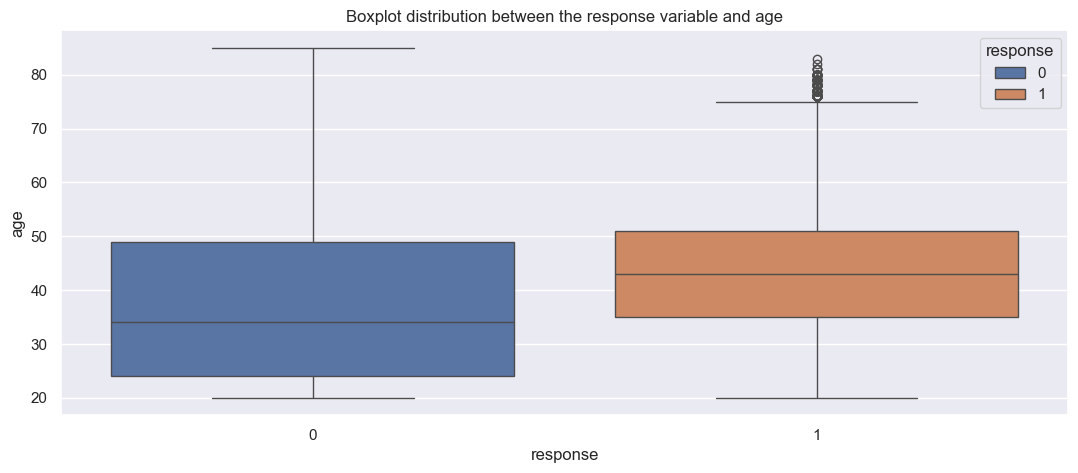

In [159]:
sns.boxplot(data = df5, x = 'response', y = 'age', hue='response')
plt.title('Boxplot distribution between the response variable and age')
plt.show()

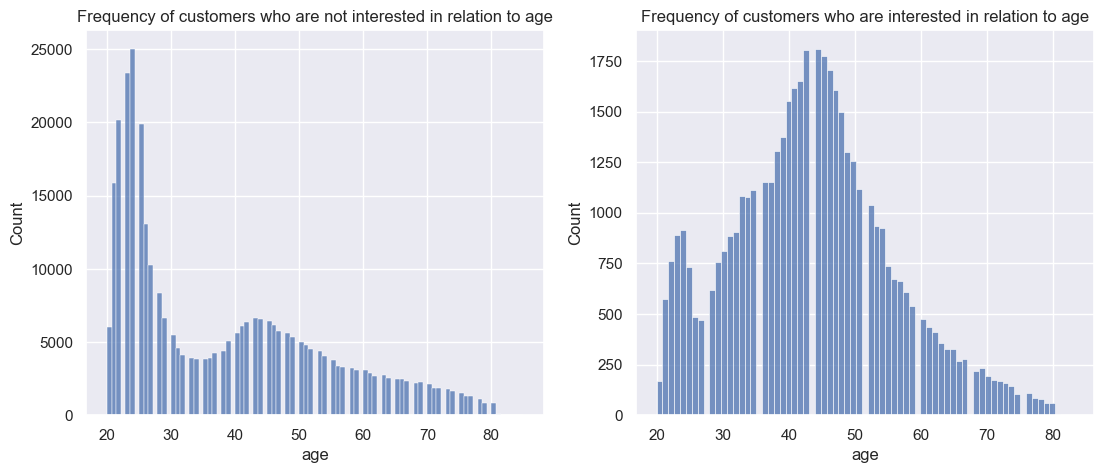

In [160]:
plt.subplot(1,2,1)
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00)
plt.title('Frequency of customers who are not interested in relation to age')

plt.subplot(1,2,2)
aux01 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux01)
plt.title('Frequency of customers who are interested in relation to age')
plt.show()

### 5.1.2 - ANNUAL PREMIUM VARIABLE

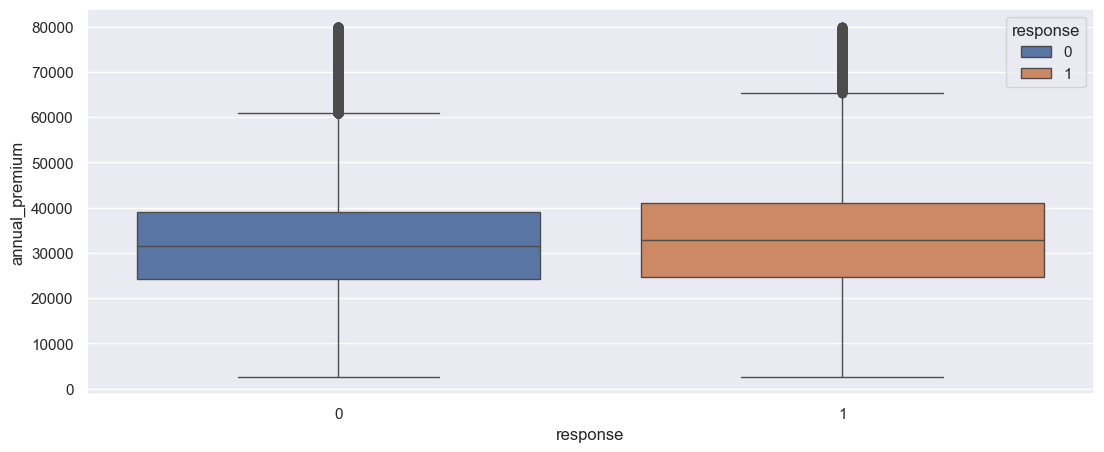

In [161]:
aux00 = df5.loc[df5['annual_premium'] < 80000]
sns.boxplot(data = aux00, x = 'response', y = 'annual_premium', hue = 'response')
plt.show()

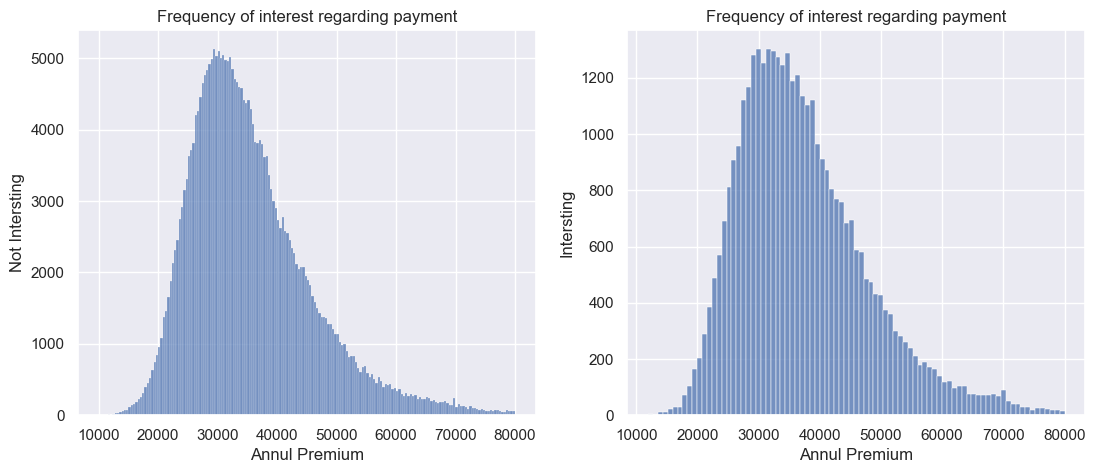

In [162]:
plt.subplot(1,2,1)
aux00 = df5.loc[(df5['annual_premium'] > 10000) & (df5['annual_premium'] < 80000)]
aux001 = aux00.loc[aux00['response'] == 0, 'annual_premium']
sns.histplot(aux001)
plt.title('Frequency of interest regarding payment')
plt.ylabel('Not Intersting')
plt.xlabel('Annul Premium')

plt.subplot(1,2,2)
aux002 = aux00.loc[aux00['response'] == 1, 'annual_premium']
sns.histplot(aux002)
plt.title('Frequency of interest regarding payment')
plt.ylabel('Intersting')
plt.xlabel('Annul Premium')
plt.show()

### 5.1.3 - DRIVING LICENSE VARIABLE

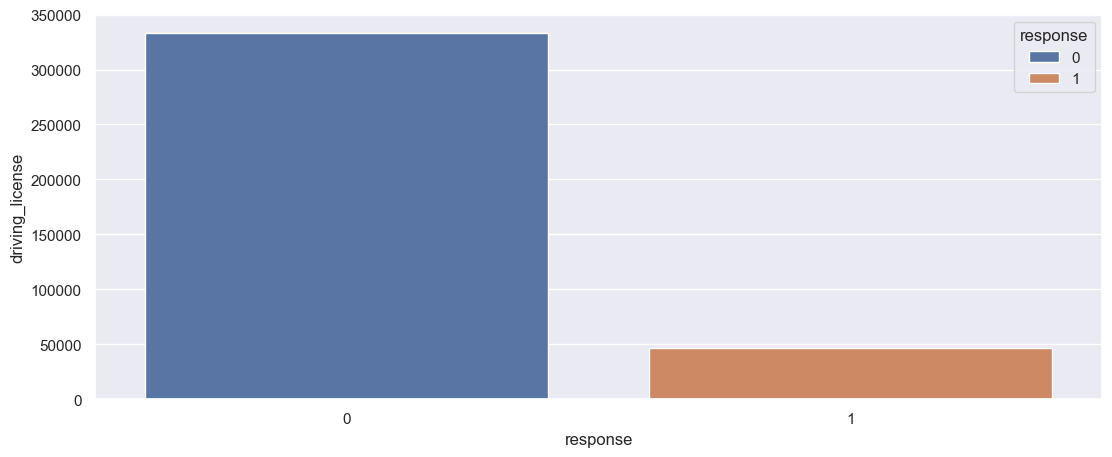

In [163]:
aux00 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(data = aux00, x = 'response', y = 'driving_license', hue = 'response')
plt.show()

In [164]:
aux00['percent'] = aux00['driving_license'] / aux00['driving_license'].sum()
aux00

,response,driving_license,percent
0,0,333628,0.877283
1,1,46669,0.122717


### 5.1.4 - REGION CODE VARIABLE

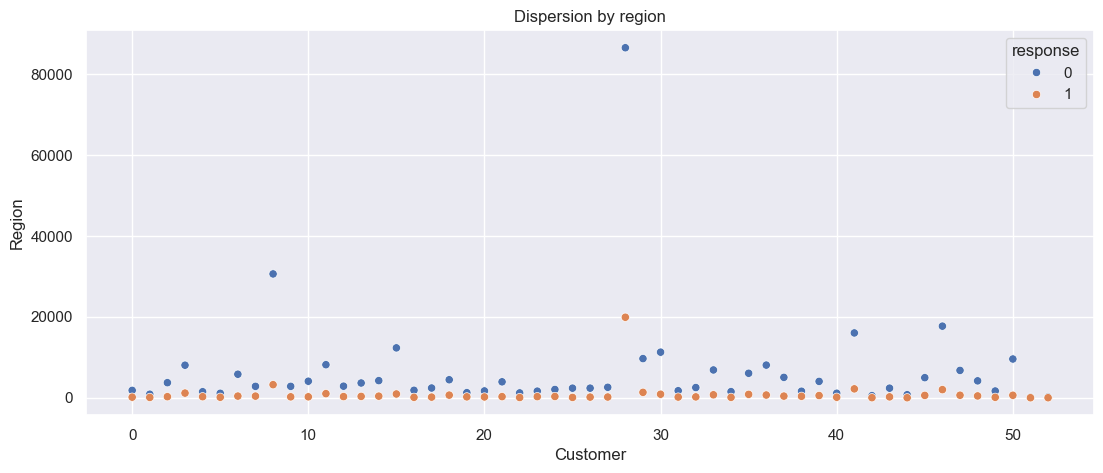

In [165]:
aux0 = df5.groupby(['region_code', 'response'])['id'].count().reset_index()
sns.scatterplot(data = aux0, x = 'region_code', y = 'id', hue = 'response')
plt.title('Dispersion by region')
plt.xlabel('Customer')
plt.ylabel('Region')
plt.show()

### 5.1.5 - PREVIOUS INSURED VARIABLE

In [166]:
pd.crosstab(df5['previously_insured'], df5['response']).apply(lambda x: x /x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 5.1.6 - VEHICLE AGE VARIABLE

In [167]:
df5[['vehicle_age', 'response']].value_counts(normalize = True).reset_index()

,vehicle_age,response,proportion
0,Between 1 and 2 Years,0,0.434285
1,Below 1 Year,0,0.413488
2,Between 1 and 2 Years,1,0.091328
3,Over 2 Years,0,0.029663
4,Below 1 Year,1,0.018897
5,Over 2 Years,1,0.012338


### 5.1.7 - POLICY SALES CHANNEL VARIABLE

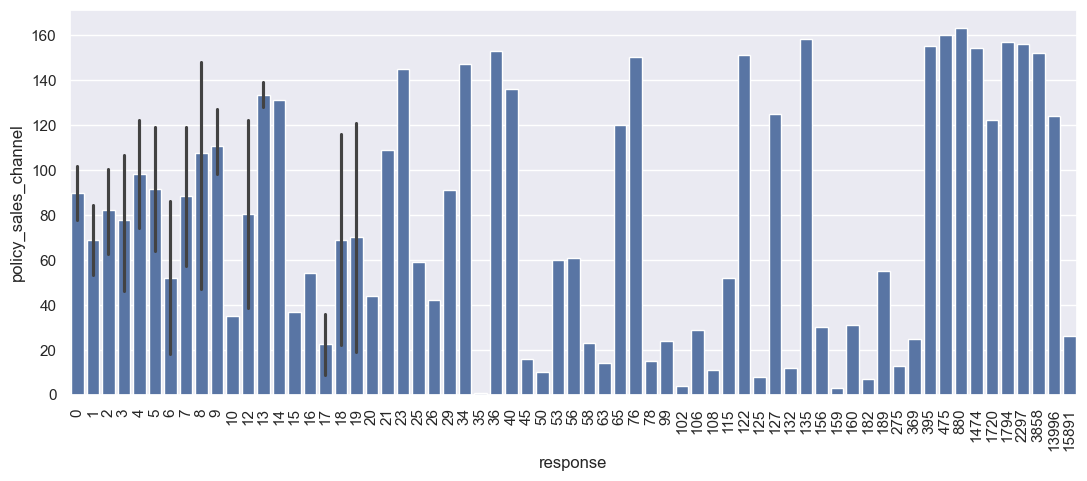

In [168]:
aux01 = df5.groupby('policy_sales_channel')['response'].sum().reset_index()
sns.barplot(data = aux01, x = 'response', y = 'policy_sales_channel')
plt.xticks(rotation = 90)
plt.show()

### 5.1.8 - VINTAGE VARIABLE

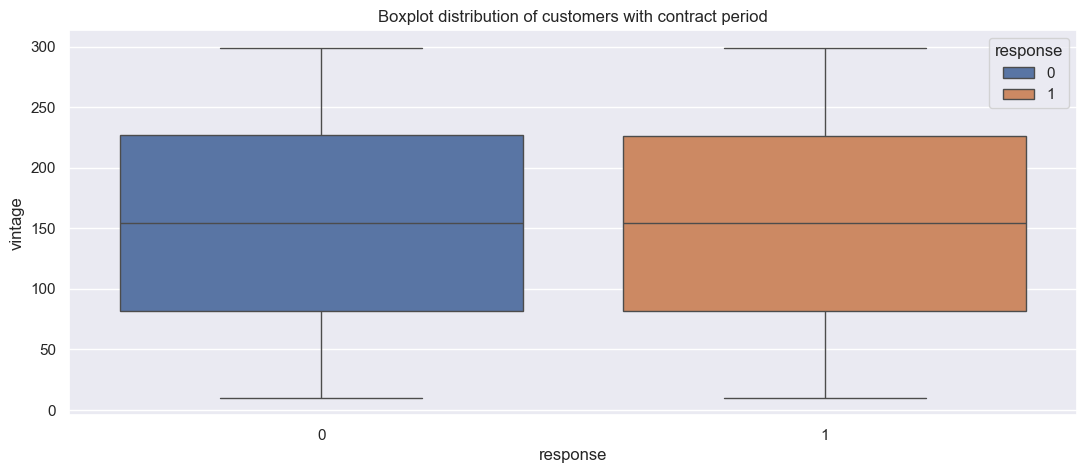

In [169]:
sns.boxplot(data = df5, x = 'response', y = 'vintage', hue='response')
plt.title('Boxplot distribution of customers with contract period')
plt.show()

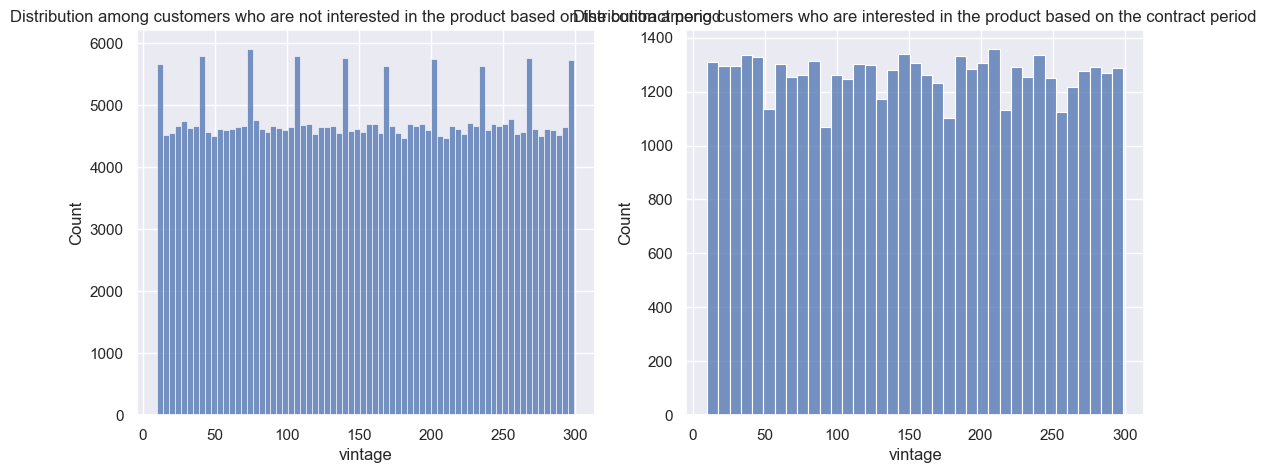

In [170]:
plt.subplot(1,2,1)
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00)
plt.title('Distribution among customers who are not interested in the product based on the contract period')

plt.subplot(1,2,2)
aux01 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux01)
plt.title('Distribution among customers who are interested in the product based on the contract period')
plt.show()

# 6.0 - DATA PREPARATION

In [171]:
df6 = df5.copy()

## 6.1 - VALIDATION DATA SPLIT

In [172]:
x = df5.drop('response', axis = 1)
y = df5['response'].copy()

x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.20)
df6 = pd.concat([x_train, y_train], axis = 1) 

## 6.2 - DATA TRANSFORM

### 6.2.1 - SCALER

StandarScaler()

In [173]:
ss_annual_premium = StandardScaler()
df6['annual_premium'] = ss_annual_premium.fit_transform(df6[['annual_premium']].values)

MinMaxScaler()

In [174]:
mms_age = MinMaxScaler()
df6['age']     = mms_age.fit_transform(df6[['age']].values)

mms_vintage = MinMaxScaler()
df6['vintage'] = mms_vintage.fit_transform(df6[['vintage']].values)

### 6.2.2 - ENCODER


TargetEncoder

In [175]:
target_encoder_rc = df6.groupby('region_code')['response'].mean()
df6.loc[:, 'region_code'] = df6['region_code'].map(target_encoder_rc)

target_encoder_gender = df6.groupby('gender')['response'].mean()
df6.loc[:, 'gender'] = df6['gender'].map(target_encoder_gender)

fe_policy_sales_channel = df6.groupby('policy_sales_channel').size() / len(df6)
df6.loc[:, 'policy_sales_channel'] = df6['policy_sales_channel'].map(fe_policy_sales_channel)


One Hot Encoder

In [176]:
df6 = pd.get_dummies(df6, prefix = 'vehicle_age', columns = ['vehicle_age'])

In [177]:
df6[['vehicle_age_Below 1 Year', 'vehicle_age_Between 1 and 2 Years', 'vehicle_age_Over 2 Years']] = df6[['vehicle_age_Below 1 Year', 'vehicle_age_Between 1 and 2 Years', 'vehicle_age_Over 2 Years']].astype(np.int64)

## 6.3 - APPLY TRANSFORMATION ON VALIDATION DATA

In [178]:
x_validation.loc[:, 'annual_premium'] = ss_annual_premium.fit_transform(x_validation[['annual_premium']].values)

x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

x_validation.loc[:, 'age']     = mms_age.fit_transform(x_validation[['age']].values)

x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encoder_rc)

x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encoder_gender)

x_validation = pd.get_dummies(x_validation, prefix = 'vehicle_age', columns = ['vehicle_age'])

x_validation  = x_validation.fillna(0)

# 7.0 - FEATURE SELECTION

## 7.1 - IMPORTANCE FEATURE

In [179]:
#select feature

x_train_n = df6.drop(['id', 'response'], axis = 1)
y_train_n = y_train.values

#model
extra_trees = ExtraTreesClassifier(n_estimators = 250, random_state = 42, n_jobs = -1)
extra_trees.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Ranking:
                             Feature  Importance
0                            vintage    0.273480
0                     annual_premium    0.245127
0                                age    0.165562
0                        region_code    0.106117
0                     vehicle_damage    0.073419
0               policy_sales_channel    0.060709
0                 previously_insured    0.050153
0           vehicle_age_Below 1 Year    0.011827
0  vehicle_age_Between 1 and 2 Years    0.005859
0                             gender    0.004683
0           vehicle_age_Over 2 Years    0.002545
0                    driving_license    0.000518


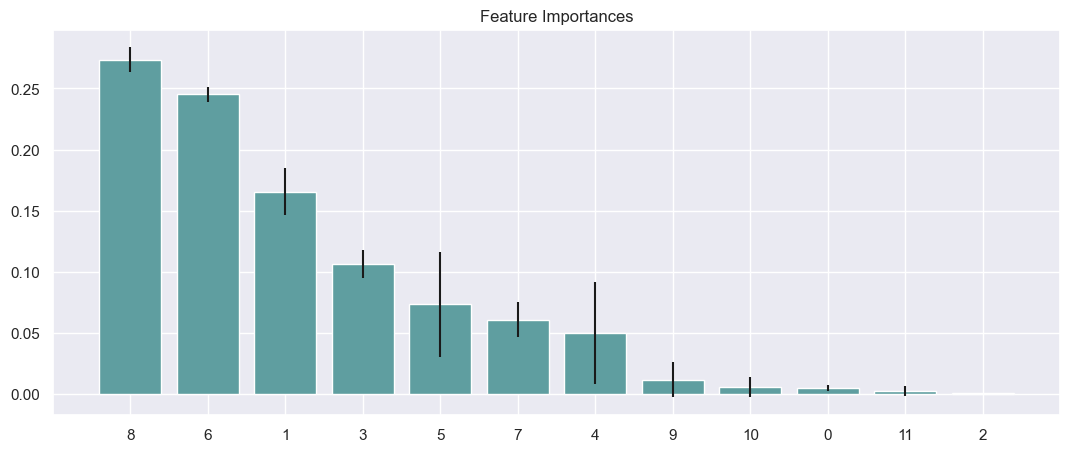

In [180]:
importances = extra_trees.feature_importances_
std = np.std([tree.feature_importances_ for tree in extra_trees.estimators_], axis=0)
indexes = np.argsort(importances)[::-1]

# Feature Ranking
print('Ranking:')
dataframe = pd.DataFrame()
for i, j in zip(x_train_n, extra_trees.feature_importances_):
    df_aux = pd.DataFrame({'Feature' : i, 'Importance': j}, index = [0])
    dataframe = pd.concat([dataframe, df_aux], axis = 0)

print(dataframe.sort_values('Importance', ascending = False))

#Plot
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indexes], color = '#5F9EA0', yerr = std[indexes], align = 'center')
plt.xticks(range(x_train_n.shape[1]), indexes)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 7.2 - BEST FEATURES

In [181]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'policy_sales_channel', 'vehicle_damage', 'previously_insured']
x_train = df6[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

# 8.0 - MACHINE LEARNING MODEL

## 8.1 - K-NEARST NEIGHBORS - KNN

In [182]:
# Create Model
knn = KNeighborsClassifier(n_neighbors = 7)

# Training Model
knn.fit(x_train, y_train)

# Predict
yhat_knn = knn.predict_proba(x_val)


## 8.2 - LOGISTIC REGRESSION - LR

In [183]:
# Create Model
lr = LogisticRegression(random_state = 42)

#Training
lr.fit(x_train, y_train)

#predict
yhat_lr = lr.predict_proba(x_val)

## 8.3 - EXTRA TREES CLASSIFIER

In [184]:
#create model
extra_trees = ExtraTreesClassifier(n_estimators = 1000, n_jobs = -1, random_state= 42)
#training
extra_trees.fit(x_train, y_train)

#predict
yhat_extrat = extra_trees.predict_proba(x_val)

## 8.3 - ACCUMULARY CURVE GAIN GRAPH

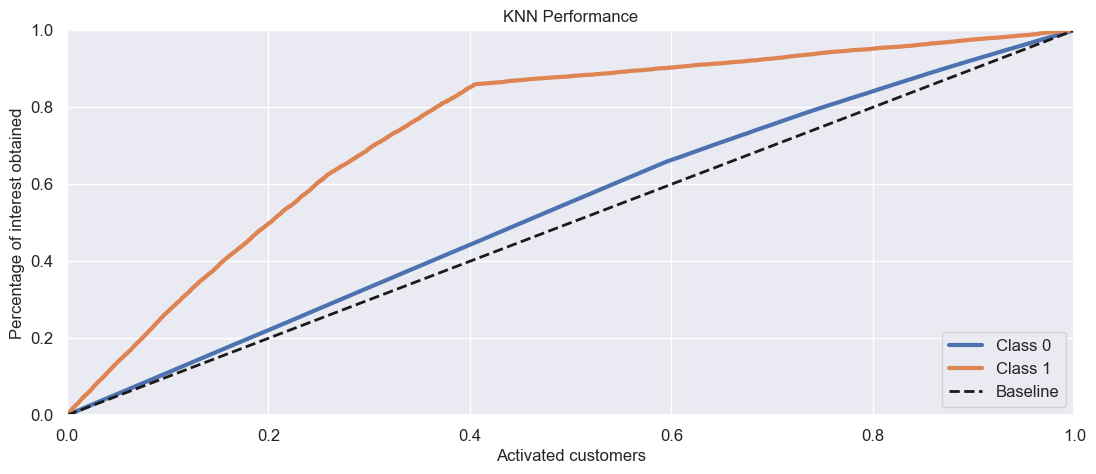

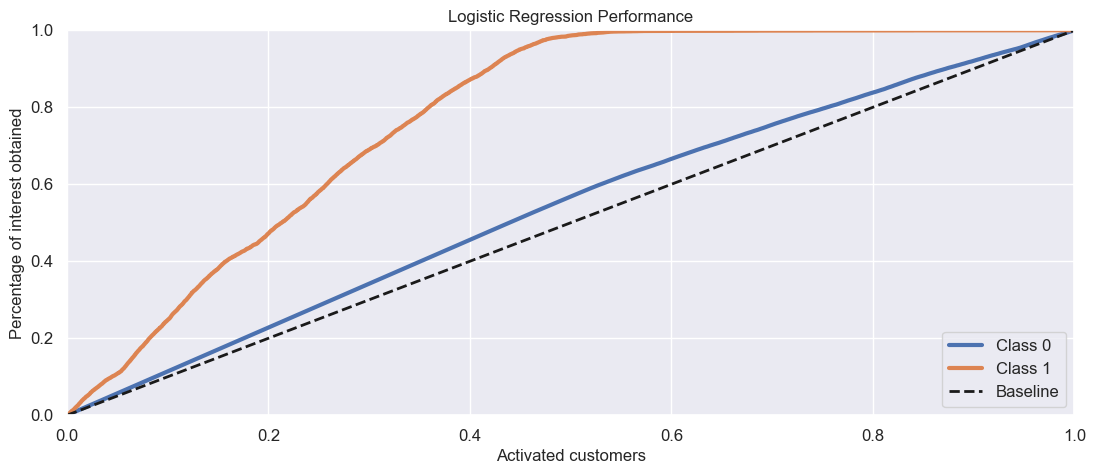

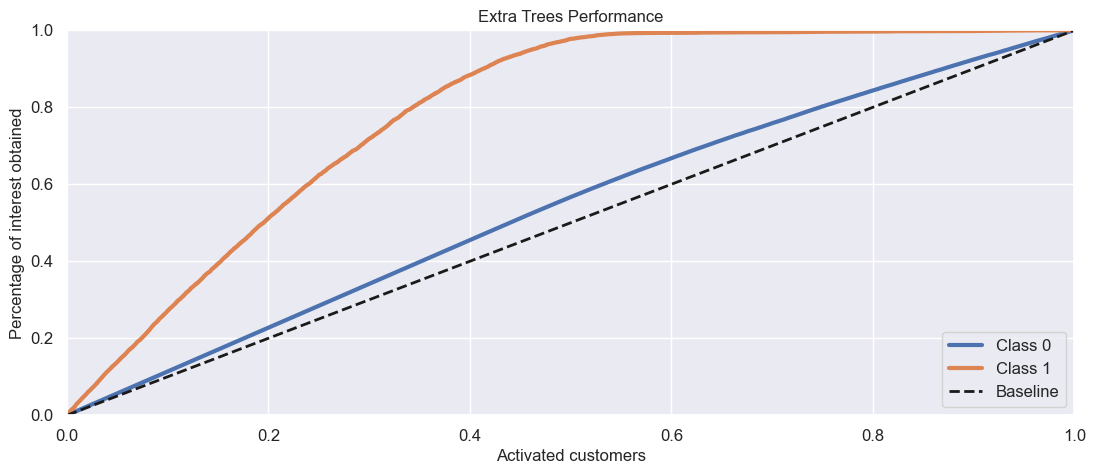

In [185]:
plot_cumulative_gain(y_val, yhat_knn)
plt.title('KNN Performance')
plt.xlabel('Activated customers')
plt.ylabel('Percentage of interest obtained')
plt.show()

plot_cumulative_gain(y_val, yhat_lr)
plt.title('Logistic Regression Performance')
plt.xlabel('Activated customers')
plt.ylabel('Percentage of interest obtained')
plt.show()

plot_cumulative_gain(y_val, yhat_extrat)
plt.title('Extra Trees Performance')
plt.xlabel('Activated customers')
plt.ylabel('Percentage of interest obtained')
plt.show()

# 9.0 - MODEL PERFORMANCE

In [261]:
#copy dataset
df9 = x_validation.copy()

# create feature 'response' using a copy of variable 'y_validation', because the values in this variable have the class prediction
df9['response'] = y_validation.copy()

#create propensity score feature
df9['propensity_score'] = yhat_knn[:, 1].tolist()

In [264]:
#precision K
print('Precision K: {}'.format(precision_k(df9, k = 50)))

#recall K
print('Recall K: {}'.format(recall_k(df9, k = 50)))

Precision K: 0.29411764705882354
Recall K: 0.001603592046183451
